# Sprint 2: Unsupervised learning

## Data Analysis

We starten door alle rijen van de dataset in te lezen, vervolgens nemen we een **willekeurige sample** set van 5000 rijen.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re, string

df_full_complaints = pd.read_csv('../data/complaints.csv', delimiter=',')

# Randomly sample 7 elements from your dataframe
complaints = df_full_complaints.sample(n=5000)
rows, cols = complaints.shape

In [3]:
complaints.Product.unique()
complaints['Product'].nunique()

17

In totaal zijn er 17 verschillende producten, daarom is het doel om uiteindelijk 17 clusters te bekomen die elk
een product categorie voorstellen. Om een idee te hebben over de verschillende categoriën van de willekeurige sample set stellen we volgend plot op volgens het aantal producten.

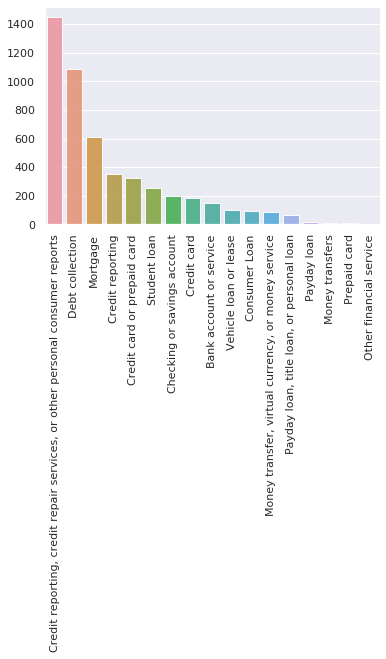

In [7]:
product_count = complaints['Product'].value_counts()
product_count 
sns.set(style="darkgrid")
ax = sns.barplot(product_count.index, product_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [4]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
206158,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,Received a collection notice from Credit Colle...
226198,Credit reporting,None,Credit reporting company's investigation,Inadequate help over the phone,When I called Social Security to secure an onl...
87704,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my third written request to block info...
368466,Bank account or service,Checking account,"Account opening, closing, or management",None,"In the past few weeks, I have been in a disput..."
53935,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,I have multiple collections notations from a c...


# 3. DBSCAN

**DBSCAN - Density-Based Spatial Clustering**. Bepaald de belangrijkste samples met een hoge densiteit en expandeert clusters van hen. Het is populair vanwege zijn flexibiliteit en variërende cluster grotes en vormen, maar ook door zijn robusheid tegen grensgevallen (outliers). 

### 3A. Data pre-processing

In [8]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return result

Narrative_Processed bevat de verwerkte de narrative data.

In [6]:
complaints_df['Narrative_Processed'] = complaints_df['Narrative'].apply(processing)

### 3B. Tf-idf Vectorizer

De matrix waarop DBSCAN wordt uitgevoerd wordt bekomen via een TF-idf vectorizer.
Elke rij komt overeen met een complaint, en de kolommen in de complaint geven de frequentie van het overeenkomstige woord aan.

* **max_df** : de maximum frequency die een feature kan hebben om gebruikt te worden in de tf-idf matrix
* **min_df**: het minimum aantal aanwezige documenten waarin het woord aanwezig is
* **ngram_range**: kijken naar unigrams, bigrams etc..
* Tf-idf is al reeds rij genormaliseerd

Om deze data te clusteren hebben we 2 dingen ondervonden
* de meest frequente woorden, die in meerdere complaint categorïen voorkomen, moeten worden weg gefiltert, anders gaan de punten van beide clusters te dicht bij elkaar komen te liggen
* wanneer min_df te klein wordt genomen zullen de berkekeningen te lang duren
* doordat het groote aantal dimensies een nadelige impact heeft op clustering worden enkel die woorden met het de hoogste frequenties( bij niet genormaliseerde clustering) genomen als features.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

#woorden die in meer dan 95% van de narratives voorkomen en woorden die in 5 of minder narratives voorkomen negeren 
#ook bigrams in rekening nemen
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5),
                                    min_df = 15, 
                                    max_df = .3,
                                    max_features=50)

#dit zijn alle features
X = tfidf_vectorizer.fit_transform(tokens)
X_array = X.toarray()
#target
y = complaints_df['Product'].values

print("De bekomen dimensies zijn:")
print(X.shape)
print(y.shape)

De bekomen dimensies zijn:
(5000, 50)
(5000,)


Om te bepalen welke waardes we moesten kiezen voor n_gram range bepaalde we de resultaten op 2 manieren, via ngram_range=(1,5) en ngram_range=(3,5), de meeste representatieve features werden bekomen via ngram_range=(3,5). Maar omdat we daarop de elleboog methode niet kunnen toepassen wordt gekozen voor ngram_range=(1,5).


### 3C. Toepassen DBSCAN - niet genormaliseerd

Bepalen van de parameters:

**min_samples**: bepaald vanaf wanneer een groep samples kan worden beschouwd als cluster, één van de belangrijkste taken van deze parameter is dus het verwijderen van outliers. Een algemene vuistregel die we initieel toepassen is als volgt: het minimum aantal punten zou groter of gelijk moeten zijn aan de dimensie van onze dataset. Typisch nemen mensen die DBSCAN gebruiken, minimum twee maal de data dimensie, 2*d. Hoe meer ruis in onze data hoe groter we deze parameter moeten kiezen.


In [22]:
# Bepalen van min_samples
dim=X.shape[1]
min_samples = 2*dim
print("min_samples wordt ingesteld op "+str(min_samples))

min_samples wordt ingesteld op 100


**eps**: legt vast hoe dicht punten bij elkaar zouden moeten liggen om als deel van een cluster beschouwd te worden. Het betekent dat als een distance tussen twee punten lager of gelijk is aan deze value, dan zijn deze punten buren.

Berkenen van de cosine distances tussen de complaints

In [23]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X.shape[0]+1):
    cosine_similarities.append(linear_kernel(X[i-1:i], X).flatten())
dist_df=pd.DataFrame(cosine_similarities)

Voor elk punt in de dataset hebben we de distances ten opzichte van de andere punten bepaald.
Sinds we onze punten in stijgende volgorde hebben gesorteerd kunnen we eps bepalen met de elbow methode.
De keuze voor epsilon zal op de hoogte van de elleboog komen te liggen.

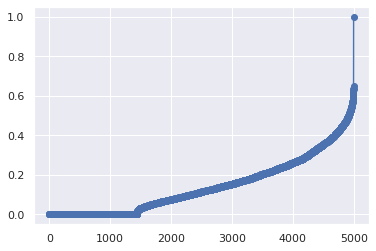

In [24]:
import matplotlib.pyplot as plt
dist_df_sorted = dist_df.sort_values([0], ascending = (True))
plt.plot(range(0,X.shape[0]), dist_df_sorted[0],marker='o')

De regel om het dubbele te nemen van min_samples gaf niet een optimaal resultaat. Er werden geen clusters gevonden, beter resultaten werden bekomen door min_sampels gelijk te stellen aan 20, de kleine categoriën worden mogelijks niet gedetecteerd.

In [39]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.4, min_samples=20)
db_fitted=db.fit_predict(dist_df)

#Storing the labels formed by the DBSCAN
labels = db.labels_

Met behulp van db.labels_ verkrijgen we de cluster labels voor elk punt in de dataset, gegeven door fit().
Aan de ruis samples wordt label -1 gegeven. Ruis samples zou in onze context kunnen betekenen dat complaints slecht zijn beschreven en een verkeerde formuleringswijze is gebruikt.

In [40]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 1 clusters.


In [41]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X_array[c] )
    else:
        clusters1[i] = [X_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))


Cluster 0 is van grootte 116


Volgende functie is afkomstig uit de labo's. Voor elke cluster wordt een ander kleur gebruikt.
De zwarte punten komen overeen met de punten die niet zijn toegewezen aan een cluster.
we merken op dat er dingen aan de dataset moeten worden aangepast. Want nu is er totaal geen clustervorming.

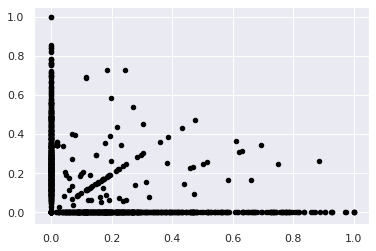

In [48]:
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    '''
    This function plots the data items, using a different color per cluster. If cluster_centers are provided, these are also plotted.
    
    Args:
    *  data: Numpy array of tuples: [[item1_x, item1_y], [item2_x, item2_y] ,... ]
    * cluster_labels: an array of integers containing the cluster number for each data item: 
    * cluster_centers: optional, an array of tuples containing the feature values of the cluster centers [[center1_x, center1_y], [center2_x,center 2_y]...]
    '''
    
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
          col = [0, 0, 0, 1]        

        plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    
plotClusters2D(X_array,db_fitted)

### 3D. Toepassen DBSCAN - genormaliseerd

De bekomen resultaten zijn niet volgens verwacht, dit is mogelijks door de slechte feature selectie.
Daarom wordt overgeschakeld naar een genormaliseerde dataset.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),
                                    min_df = 3, 
                                    max_df = .2)

#dit zijn alle features
X2= tfidf_vectorizer.fit_transform(tokens)
X2_array = X2.toarray()
#target
y2 = complaints_df.head(10000)['Product'].values

print(X2.shape)
print(y2.shape)

(5000, 30828)
(5000,)


**Truncated SVD** wordt gebruikt als dimensionality reduction. In tegenstelling tot PCA wordt de data niet vooraf gecentreerd.<br />
Deze methode houd dus in dat het efficiënt kan omgaan met sparse matrices, en daarom wordt dit vaak gebruikt in combinatie met tf-idf.

In [8]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=2)

# Create a KMeans instance: kmeans
X2_fitted=svd.fit_transform(X2)

In [9]:
X2_fitted.shape

(5000, 2)

In [10]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X2_fitted.shape[0]+1):
    cosine_similarities.append(linear_kernel(X2_fitted[i-1:i], X2_fitted).flatten())
dist_df2=pd.DataFrame(cosine_similarities)

Epsilon wordt gekozen door 1 punt te nemen, deze waarde kunnen echter per punt verschillen maar in het algemeen merken we dat de waarde voor de meeste punten overeenkomt.
Deze methode (de elleboog methode om eps) te bepalen gebeurt op dezelfde manier als in het niet-genormaliseerde deel.

In [ ]:
import matplotlib.pyplot as plt
dist_df2_sorted = dist_df2.sort_values([6], ascending = (True))
plt.plot(range(0,X2_fitted.shape[0]), dist_df2_sorted[6],marker='o')

In [107]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.004, min_samples=20)
db_X=db.fit_predict(X2_fitted)

#Storing the labels formed by the DBSCAN
labels = db.labels_

Functie afkomstig uit de labo's, bedoeld om de clustering te visualizeren.

In [108]:
from sklearn.cluster import KMeans
import numpy as np

#use this function to visualize the clustering
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k != -1:
          # Black used for points not assigned to a cluster (will be useful for other algorithms, k-means assigns each element to a cluster)
            plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    


#### Waardes bekomen voor 2 features.
Met als parameters 
* eps=0.005, min_samples=20
* en 2 features

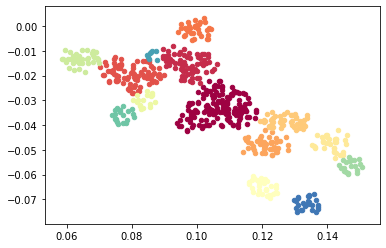

In [109]:
plotClusters2D(X2_fitted,db_X)

In [102]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 12 clusters.


In [103]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 1259
Cluster 7 is van grootte 20
Cluster 5 is van grootte 29
Cluster 3 is van grootte 42
Cluster 10 is van grootte 21
Cluster 1 is van grootte 52
Cluster 9 is van grootte 32
Cluster 8 is van grootte 24
Cluster 6 is van grootte 39
Cluster 2 is van grootte 31
Cluster 4 is van grootte 29
Cluster 11 is van grootte 21


#### Waardes bekomen voor 100 features.
Met als parameters 
* eps=0.3, min_samples=20
* en 100 features

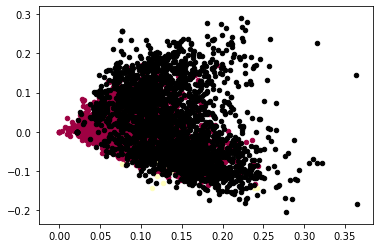

In [54]:
plotClusters2D(X2_fitted,db_X)

In [55]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 2 clusters.


In [56]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 2534
Cluster 1 is van grootte 20


#### Waardes bekomen voor 20 features.
Met als parameters 
* eps=0.09, min_samples=20
* en 20 features

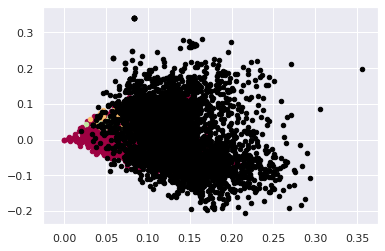

In [160]:
plotClusters2D(X2_fitted,db_X)

In [161]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 3 clusters.


In [163]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))

Cluster 0 is van grootte 1878
Cluster 1 is van grootte 55
Cluster 2 is van grootte 32


#### Waardes bekomen voor 5 features.
Met als parameters 
* eps=0.05, min_samples=20
* en 5 features

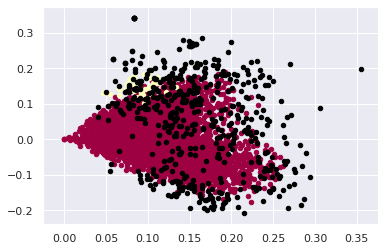

In [104]:
plotClusters2D(X2_fitted,db_X)

In [105]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print("In totaal zijn er "+str(n_clusters_)+ " clusters.")

In totaal zijn er 2 clusters.


In [106]:
clusters1 = {}
for c, i in enumerate(labels1):
    # als het een ruis punt is, overslaan
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X2_array[c] )
    else:
        clusters1[i] = [X2_array[c]]
for c in clusters1:
    print("Cluster "+str(c)+ " is van grootte "+str(len(clusters1[c])))


Cluster 0 is van grootte 4439
Cluster 1 is van grootte 51


Als eindconclusie kunnen we stellen dat de waarden verkregen door normalisering toe te passen het beste resultaat geven, ook moeten de dimensies worden beperkt door het verkrijgen van een sparse matrix bij tf idf.